# 이미지 100개 정도를 벡터화

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

사전 학습된 모델 생성

In [4]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg16 import preprocess_input
#
# def get_model():
#     pretrained_vgg16 = VGG16(weights="imagenet", include_top=True)
#     return Model(inputs=pretrained_vgg16.input, outputs=pretrained_vgg16.get_layer('fc2').output)

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from efficientnet.keras import preprocess_input

def get_model():
    pretrained_efficientnet = EfficientNetB0(weights="imagenet", include_top=True)
    return Model(inputs=pretrained_efficientnet.input, outputs=pretrained_efficientnet.get_layer('top_dropout').output)

2023-06-14 18:50:58.578308: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
model = get_model()

deepFashion 이미지 중 일부를 벡터화

In [7]:
from tensorflow.keras.preprocessing import image

def read_txt_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]


def generate_features(image_paths):
    images = np.zeros(shape=(len(image_paths), 224, 224, 3))
    for i, f in enumerate(image_paths):
        img = image.load_img(f, target_size=(224, 224))
        x_raw = image.img_to_array(img)
        x_expand = np.expand_dims(x_raw, axis=0)
        images[i, :, :, :] = x_expand
    inputs = preprocess_input(images)
    images_features = model.predict(inputs)
    return images_features


root_path = '/Users/user/workspace/personal/practice-mlops/2.build-tensorflow-model/data'
image_paths = read_txt_file(root_path + '/sample.txt')
image_paths = [os.path.join(root_path, path) for path in image_paths]

features = generate_features(image_paths)

category_numbers = read_txt_file(root_path + '/sample_cate.txt')
category_numbers = [int(num) for num in category_numbers]

category_list = read_txt_file(root_path + '/list_category_cloth.txt')[2:]  # Skip first two lines

categories = [category_list[num-1] for num in category_numbers]  # 1-indexed

1/1 [==============================] - 2s 2s/step


In [8]:
type(features)

numpy.ndarray

In [9]:
features.shape

(10, 1280)

In [10]:
features[0]

array([-0.10741259, -0.18590444, -0.18922736, ..., -0.19562055,
       -0.06734131,  0.08830036], dtype=float32)

# 벡터화된거 차원축소해서 클러스터링 해본다

PCA, UMAP, t-SNE 등을 통해 2차원 차원 축소 후 클러스터링 시각화를 해볼 수 있다

In [11]:
# from sklearn.decomposition import PCA
#
# # Applying PCA to reduce the features to 2D for visualization
# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(features)
#
# fig, ax = plt.subplots()
#
# for category in set(categories):
#     ix = np.where(np.array(categories) == category)
#     ax.scatter(principalComponents[ix, 0], principalComponents[ix, 1], label=category)
#
# ax.legend()
# plt.show()

In [12]:
# from sklearn.decomposition import PCA
#
# # Select a subset of categories to visualize
# selected_categories = set(categories[:5])  # Select the first 5 categories
#
# # Applying PCA to reduce the features to 2D for visualization
# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(features)
#
# fig, ax = plt.subplots()
#
# for category in selected_categories:
#     ix = np.where(np.array(categories) == category)
#     ax.scatter(principalComponents[ix, 0], principalComponents[ix, 1], label=category)
#
# ax.legend()
# plt.show()

차원이 높아서 그런지, 아니면 사용한 모델이 문제인지, 아니면 fashion 중 특정 옷들에 대한 분류가 어려운건지 클러스터링이 제대로 된 것 같지는 않다

# knn search 테스트

## sample data GCS 업로드

```bash
gcloud init
gcloud auth list
gcloud auth login
gcloud config set project white-outlook-389109

gsutil ls -r gs://image_semantic_search
gsutil -m cp ./data/img/Butterfly_Print_Blouse/img_00000040.jpg gs://image_semantic_search/data/img/Butterfly_Print_Blouse/img_00000040.jpg
```

## index 생성

```bash
curl -XPUT "http://34.68.94.225:9200/image-semantic-search-20230607" -H 'Content-Type: application/json' -d '
{
  "settings": {
    "index": {
      "knn": "true",
      "knn.algo_param": {
        "ef_search": "512"
      },
      "number_of_shards": "1",
      "number_of_replicas": "0"
    }
  },
  "mappings": {
    "properties": {
      "name": {
        "type": "text"
      },
      "image_url": {
        "type": "float"
      },
      "vector": {
        "type": "knn_vector",
        "dimension": "1280",
        "method": {
          "name": "hnsw",
          "space_type": "cosinesimil",
          "engine": "nmslib",
          "parameters": {
            "ef_construction": 256,
            "m": 48
          }
        }
      }
    }
  }
}'
```

## sample data 벡터화, 색인

In [13]:
root_path = '/Users/user/workspace/personal/practice-mlops/2.build-tensorflow-model/data'
image_paths = read_txt_file(root_path + '/sample.txt')
image_paths = [os.path.join(root_path, path) for path in image_paths]

features = generate_features(image_paths)

1/1 [==============================] - 0s 403ms/step


In [14]:
names = []

for image_path in image_paths:
    words = image_path.split('/')
    name = words[-2] + '_' + words[-1]
    names.append(name)

names

['Butterfly_Print_Blouse_img_00000040.jpg',
 'Varsity-Striped_Tee_img_00000008.jpg',
 'Distressed_Denim_Mini_Skirt_img_00000072.jpg',
 'Collarless_Woven_Blazer_img_00000020.jpg',
 'Pin_Dot_Suit_Jacket_img_00000024.jpg',
 'Geo_Print_Strappy_Maxi_Dress_img_00000024.jpg',
 'Embroidered_Gauze_Peasant_Dress_img_00000005.jpg',
 'Twisted-Hem_Plaid_Blouse_img_00000095.jpg',
 'Tribal_Print_Cutout_Back_Dress_img_00000027.jpg',
 'Crisscross_Back_Crepe_Jumpsuit_img_00000042.jpg']

In [33]:
image_urls = []

for image_path in image_paths:
    words = image_path.split('/')
    url = '/'.join(['https://storage.googleapis.com/image_semantic_search', words[-4], words[-3], words[-2], words[-1]])
    image_urls.append(url)

image_urls

['https://storage.googleapis.com/image_semantic_search/data/img/Butterfly_Print_Blouse/img_00000040.jpg',
 'https://storage.googleapis.com/image_semantic_search/data/img/Varsity-Striped_Tee/img_00000008.jpg',
 'https://storage.googleapis.com/image_semantic_search/data/img/Distressed_Denim_Mini_Skirt/img_00000072.jpg',
 'https://storage.googleapis.com/image_semantic_search/data/img/Collarless_Woven_Blazer/img_00000020.jpg',
 'https://storage.googleapis.com/image_semantic_search/data/img/Pin_Dot_Suit_Jacket/img_00000024.jpg',
 'https://storage.googleapis.com/image_semantic_search/data/img/Geo_Print_Strappy_Maxi_Dress/img_00000024.jpg',
 'https://storage.googleapis.com/image_semantic_search/data/img/Embroidered_Gauze_Peasant_Dress/img_00000005.jpg',
 'https://storage.googleapis.com/image_semantic_search/data/img/Twisted-Hem_Plaid_Blouse/img_00000095.jpg',
 'https://storage.googleapis.com/image_semantic_search/data/img/Tribal_Print_Cutout_Back_Dress/img_00000027.jpg',
 'https://storage.goo

In [34]:
documents = []

for i in range(len(features)):
    documents.append({
        'name': names[i],
        'image_url': image_urls[i],
        'vector': features[i]
    })

documents[0]

{'name': 'Butterfly_Print_Blouse_img_00000040.jpg',
 'image_url': 'https://storage.googleapis.com/image_semantic_search/data/img/Butterfly_Print_Blouse/img_00000040.jpg',
 'vector': array([-0.10741259, -0.18590444, -0.18922736, ..., -0.19562055,
        -0.06734131,  0.08830036], dtype=float32)}

In [17]:
from elasticsearch import Elasticsearch

# Elasticsearch 클라이언트 초기화
# es = Elasticsearch([{'host': 'http://34.68.94.225', 'port': 9200}])
host = "34.68.94.225"
index_name = "image-semantic-search-20230607"
es = Elasticsearch(f"http://{host}:9200")

In [35]:
def index_write(client, index_name, documents):
    for document in documents:
        client.index(index=index_name, id=document['name'], body=document)

index_write(es, index_name, documents)

## KNN search

In [19]:
root_path = '/Users/user/workspace/personal/practice-mlops/2.build-tensorflow-model/data'
image_paths = read_txt_file(root_path + '/sample.txt')
image_paths = [os.path.join(root_path, path) for path in image_paths]

features = generate_features(image_paths)

1/1 [==============================] - 0s 360ms/step


In [20]:
type(features)

numpy.ndarray

In [21]:
features.shape

(10, 1280)

In [22]:
type(features[0])

numpy.ndarray

In [23]:
import requests
import json

def knn_search(host, index_name, vector):
    # Elasticsearch 서버 URL 생성
    url = f"http://{host}:9200/{index_name}/_search"

    # KNN 검색 요청 데이터 생성
    data = {
        "size": 10,
        "query": {
            "knn": {
                "vector": {
                    "vector": vector.tolist(),
                    "k": 10
                }
            }
        }
    }

    # JSON 데이터로 변환
    json_data = json.dumps(data)

    # POST 요청으로 KNN 검색 수행
    response = requests.post(url, headers={"Content-Type": "application/json"}, data=json_data)

    # 응답 결과 처리
    if response.status_code == 200:
        result = response.json()
        # 결과 처리 작업 수행
        # 예시로 결과를 출력
        hits = result.get("hits", {}).get("hits", [])
        return hits
    else:
        print(f"Error: {response.status_code}")

In [36]:
result = knn_search(host, index_name, features[0])
result

[{'_index': 'image-semantic-search-20230607',
  '_id': 'Butterfly_Print_Blouse_img_00000040.jpg',
  '_score': 1.0,
  '_source': {'name': 'Butterfly_Print_Blouse_img_00000040.jpg',
   'image_url': 'https://storage.googleapis.com/image_semantic_search/data/img/Butterfly_Print_Blouse/img_00000040.jpg',
   'vector': [-0.10741259157657623,
    -0.18590444326400757,
    -0.18922735750675201,
    -0.1087857261300087,
    -0.17905832827091217,
    0.011591235175728798,
    -0.0804348960518837,
    -0.17508311569690704,
    -0.1164173036813736,
    -0.2020801603794098,
    0.059696264564991,
    -0.10486926138401031,
    -0.2404695749282837,
    -0.05686693266034126,
    -0.260535329580307,
    0.019959766417741776,
    -0.18612824380397797,
    0.2041836977005005,
    0.3187582194805145,
    -0.12632879614830017,
    -0.13494352996349335,
    -0.13402338325977325,
    0.440489798784256,
    -0.1662154346704483,
    -0.032807428389787674,
    0.5383195281028748,
    -0.23304422199726105,
    -0

In [39]:
import urllib.request
import matplotlib.pyplot as plt
from PIL import Image

def visualize_images_from_urls(image_urls):
    num_images = len(image_urls)
    num_rows = (num_images + 4) // 5  # 한 줄에 5개씩 배치하기 위해 필요한 행의 개수

    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for i, image_url in enumerate(image_urls):
        # 이미지 다운로드
        urllib.request.urlretrieve(image_url, f'image_{i}.jpg')

        # 이미지 열기
        image = Image.open(f'image_{i}.jpg')

        # 이미지 출력
        axes[i].imshow(image)
        axes[i].axis('off')

    # 남은 빈 서브플롯 삭제
    for j in range(num_images, num_rows * 5):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    for i in range(num_images):
        file_path = f'image_{i}.jpg'
        if os.path.exists(file_path):
            os.remove(file_path)

In [37]:
result[0]['_source']['image_url']

'https://storage.googleapis.com/image_semantic_search/data/img/Butterfly_Print_Blouse/img_00000040.jpg'

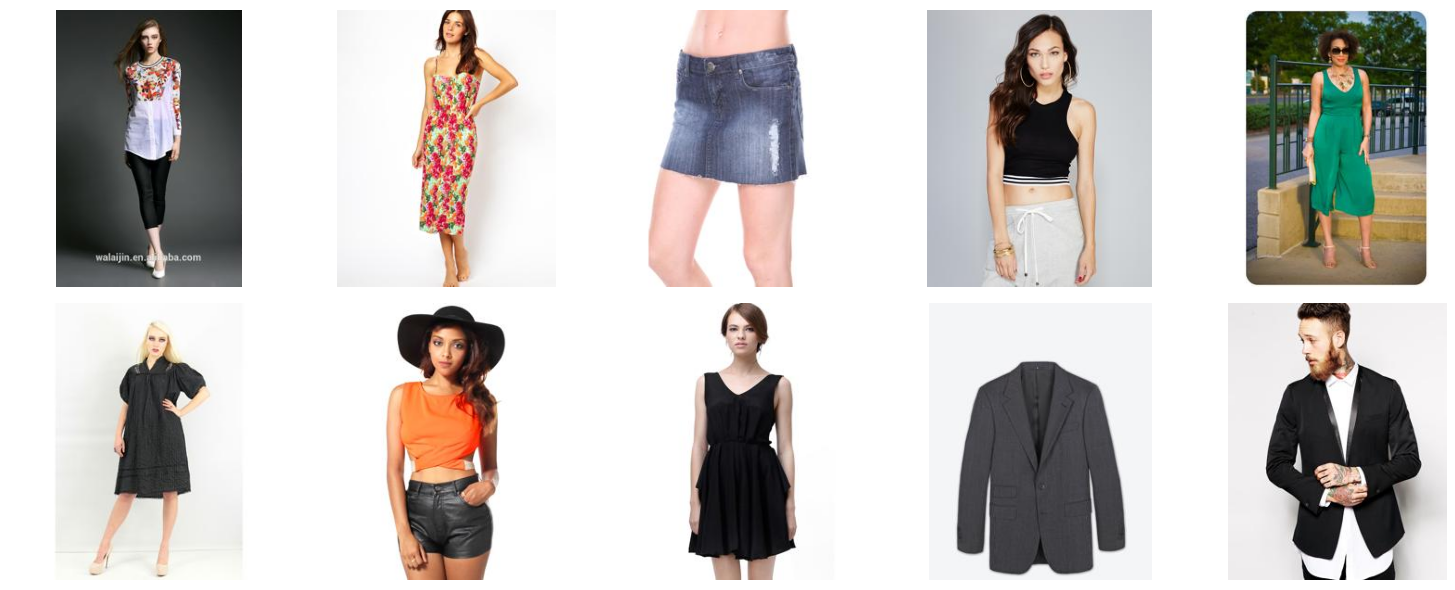

In [40]:
image_urls = [entry['_source']['image_url'] for entry in result]
visualize_images_from_urls(image_urls)